In [1]:
import argparse
from pathlib import Path
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
import json
from models import UNet11
from dataset import WaterDataset
from torch.optim import lr_scheduler 
import torch.optim as optim
import numpy as np
import glob
import os
from metrics_prediction import calc_loss
import matplotlib.pyplot as plt
import utils_plot

from get_train_test_kfold import get_split_out, percent_split, get_split_in

from split_train_val import get_files_names
from scalarmeanstd import meanstd

from transformsdata import (DualCompose,
                        ImageOnly,
                        Normalize,
                        Normalize2,
                        HorizontalFlip,
                        Rotate,
                        CenterCrop,
                        VerticalFlip)

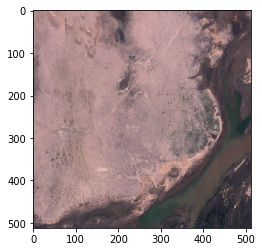

In [2]:
img = np.load(os.path.join('data/','train_val_850_2/images/rgbnir24608-3072.npy'))[:3]
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img.transpose(1,2,0))

## Definitions

In [3]:
num_classes = 1
input_channels = 4
batch_size = 4
lr = 0.005

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [5]:
#Definition of teacher model
model_teach = UNet11(num_classes=num_classes, input_channels=input_channels)

In [6]:
#Definition of student model
model_stud = UNet11(num_classes=num_classes, input_channels=input_channels)

In [7]:
if torch.cuda.is_available():
    model_teach = nn.DataParallel(model_teach, device_ids=[0])
    #model_stud = nn.DataParallel(model_stud).to(device)

In [8]:
data_path = Path("data/")


#Labeled images
train_val_file_names = np.array(sorted(glob.glob(str((data_path/'train_val_850_2'/'images'))+ "/*.npy")))
test_file_names = np.array(sorted(glob.glob(str((data_path/'test_850_2'/'images')) + "/*.npy")))

train_file_lab,val_file_lab = get_split_in(train_val_file_names,0)

max_values, mean_values, std_values=meanstd(train_file_lab, val_file_lab,test_file_names,str(data_path),input_channels)

#Unlabeled images

train_path_unlab= data_path/'unlabel'/'train'/'images'
val_path_unlab = data_path/'unlabel'/'val'/'images'

train_file_unlab = np.array(sorted(list(train_path_unlab.glob('*.npy'))))

val_file_unlab = np.array(sorted(list(val_path_unlab.glob('*.npy'))))

print(mean_values, std_values, max_values)

elapsed time: 5.788986058905721
Train: data 751 min  0 max  3521
mean:[ 0.11289885  0.10246669  0.11346575  0.1396483 ]
std:[ 0.08914584  0.0666959   0.05693271  0.11042776]
Val: data 188 min  0 max  3440
mean:[ 0.11717311  0.10560063  0.1165011   0.13805926]
std:[ 0.09240376  0.06936888  0.05979758  0.11221593]
Test: data 182 -min  0 max  3272
mean:[ 0.10808238  0.09674959  0.10814647  0.13168366]
std:[ 0.08546968  0.06265724  0.05298235  0.10878518]
All: data 945 min  0 max  3521
mean:[ 0.11383374  0.10310764  0.11405758  0.13963067]
std:[ 0.08972336  0.06713878  0.05742005  0.11076992]
[ 0.11289885  0.10246669  0.11346575  0.1396483 ] [ 0.08914584  0.0666959   0.05693271  0.11042776] 3521


In [9]:
def make_loader(file_names, shuffle=False, transform=None, limit=None,  mode = "train",batch_size=4,limite=None) :
    return DataLoader(
        dataset=WaterDataset(file_names, transform=transform, mode = mode,limit=limit),
        shuffle=shuffle,
        batch_size= batch_size,
        pin_memory=torch.cuda.is_available() 
    )

## Transformations

In [10]:
train_transform = DualCompose([
    CenterCrop(512),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])

val_transform = DualCompose([
    CenterCrop(512),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])

train_transform_unlab = DualCompose([
    CenterCrop(512),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])

val_transform_unlab = DualCompose([
    CenterCrop(512),
    ImageOnly(Normalize(mean_values, std=std_values))
])

In [11]:
train_loader_lab = make_loader(train_file_lab, shuffle=True, transform=train_transform , batch_size = batch_size , mode = "train")
valid_loader_lab = make_loader(val_file_lab, transform=val_transform, batch_size = batch_size, mode = "train")

train_loader_unlab = make_loader(train_file_unlab, shuffle=True, transform=train_transform, batch_size = batch_size//2, mode = "unlb_train")
valid_loader_unlab = make_loader(val_file_unlab, transform=val_transform, batch_size = batch_size//2, mode = "unlb_val")

In [12]:
dataloaders_lab= {
    'train': train_loader_lab, 'val': valid_loader_lab
}

dataloaders_unlab= {
    'train': train_loader_unlab, 'val': valid_loader_unlab
}

In [13]:
dataloaders_sizes = {
    x: len(dataloaders_lab[x]) for x in dataloaders_lab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 188, 'val': 47}


## Printing some images and labels

Training images (only RGB)
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])


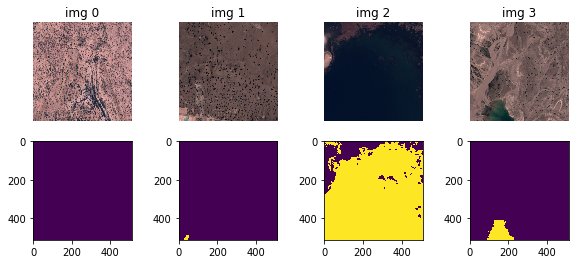

In [14]:
print('Training images (only RGB)')
images, labels = next(iter(train_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    ax.imshow(labels[ii].squeeze().numpy())

Validation images (only RGB)
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])


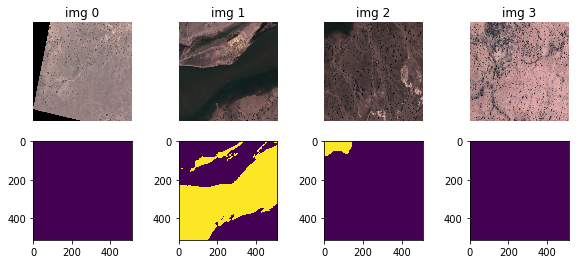

In [15]:
print('Validation images (only RGB)')
images, labels = next(iter(valid_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    ax.imshow(labels[ii].squeeze().numpy())

In [16]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

## Training the Teacher Model

In [17]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 10
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [18]:
#Initializing model weights, loss and output file
import copy
import time
from collections import defaultdict
best_model_teach_wts = copy.deepcopy(model_teach.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [19]:
for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])
                f.write("LR" +  str(param_group['lr']) + "\n") 

            model_teach.train()  # Set model to training mode
        else:
            model_teach.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_lab, labels_lab= next(iter(dataloaders_lab[phase]))    

            input_lab = input_lab.to(device)
            labels_lab = labels_lab.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_lab = model_teach(input_lab)
                loss = calc_loss(pred_lab, labels_lab, metrics)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples_loss += input_lab.size(0)
            epoch_samples_l2 += input_lab.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        print('{} loss {:.3f}'.format(phase, epoch_loss))
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_teach_wts = copy.deepcopy(model_teach.state_dict())


    time_elapsed = time.time() - since
    print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

------------------------ EPOCH 0 ------------------------
LR 0.005


/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss 42233.925
val loss 0.414
Saving best model...
Time elapsed: 0m 10s
------------------------ EPOCH 1 ------------------------
LR 0.005
train loss 0.762
val loss 0.327
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 2 ------------------------
LR 0.005
train loss 0.407
val loss 0.374
Time elapsed: 0m 9s
------------------------ EPOCH 3 ------------------------
LR 0.005
train loss 0.407
val loss 0.283
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 4 ------------------------
LR 0.005
train loss 0.325
val loss 0.271
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 5 ------------------------
LR 0.005
train loss 0.276
val loss 0.261
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 6 ------------------------
LR 0.005
train loss 0.265
val loss 0.245
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 7 ------------------------
LR 0.005
train loss 0.245
val loss 0.220
Savi

In [20]:
model_teach.load_state_dict(best_model_teach_wts)

<All keys matched successfully>

## Generating pseudo-labels for student model

In [25]:
for param in model_teach.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0112, -0.0089,  0.0023],
          [ 0.0453,  0.0003, -0.0046],
          [ 0.1334, -0.0431, -0.1464]],

         [[ 0.0019, -0.0284,  0.0352],
          [-0.1055, -0.0243,  0.0209],
          [-0.0239,  0.0387,  0.0113]],

         [[-0.0291, -0.0850, -0.0082],
          [ 0.0157,  0.0111, -0.0980],
          [-0.0763,  0.0088, -0.0115]]],


        [[[ 0.0254,  0.0286, -0.0334],
          [ 0.0574, -0.0086, -0.0687],
          [-0.1016,  0.0298,  0.0167]],

         [[-0.0431, -0.1099,  0.0073],
          [ 0.0388,  0.0264, -0.0122],
          [ 0.0311, -0.0043, -0.0177]],

         [[ 0.0452, -0.0279,  0.0674],
          [-0.0543,  0.0715, -0.0070],
          [-0.1188, -0.0615,  0.0123]]],


        [[[ 0.0122,  0.0215,  0.0040],
          [-0.0372, -0.0302, -0.0081],
          [ 0.0297,  0.0078, -0.0668]],

         [[ 0.0133, -0.0234, -0.0816],
          [-0.0402,  0.0756,  0.0661],
          [ 0.0183,  0.0267,  0.0790]],

         [[-0.0480, -0

Parameter containing:
tensor([-3.4421e-02, -3.7304e-02, -3.1178e-02, -2.8555e-02, -1.9338e-02,
        -2.6111e-02, -2.7637e-02, -2.9374e-02, -4.1333e-02, -3.3839e-02,
        -1.2758e-02, -2.2157e-02, -2.4217e-02, -2.8563e-02, -6.9665e-02,
        -2.5659e-02, -4.0372e-02, -1.4072e-02, -2.5240e-02, -3.6306e-02,
        -8.9505e-03, -3.0887e-02, -2.0065e-02, -2.2188e-02, -1.5938e-02,
        -1.2213e-02, -3.9422e-02, -3.4311e-02, -1.8215e-02, -3.6464e-02,
        -2.1776e-02, -8.5115e-03, -2.5914e-02, -3.6597e-02, -3.5513e-02,
        -5.7172e-02, -1.4969e-02, -3.7625e-02, -2.9862e-02, -1.8254e-02,
        -3.0232e-03, -3.7752e-02, -3.3216e-02, -3.7394e-02, -2.1894e-02,
        -2.9685e-02, -2.9339e-02, -3.4713e-02, -3.7562e-02, -3.0205e-02,
        -1.1187e-02, -1.9466e-02, -1.3236e-02, -2.2980e-02, -2.8507e-02,
        -3.8583e-02, -4.2609e-02,  1.3315e-02, -3.7837e-02, -2.5018e-02,
        -3.2687e-02, -3.3461e-02, -4.7706e-02, -3.2294e-02, -3.1318e-02,
        -3.2127e-02, -1.3078e